In [1]:
import pickle
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
path_model = 'E:/YNU/5/OpenSourceGIS/Act_7/OnClass/model_rf.pickle'
path_rsimg = 'E:/YNU/5/OpenSourceGIS/Act_7/OnClass/chenggong_utm48.tif'

In [3]:
rsimg_rio = rio.open(path_rsimg) # 打开遥感影像文件
rsimg_rio.meta # 查看影像文件的元数据

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 2875,
 'height': 3379,
 'count': 6,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]'),
 'transform': Affine(10.421454790528236, 0.0, 268167.02525260474,
        0.0, -9.543567381150961, 2765453.1872716597)}

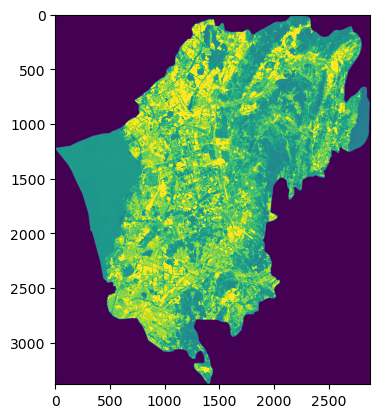

In [4]:
rsimg_arr = rsimg_rio.read()  # 读取影像数据
rsimg_arr = rsimg_arr.transpose(1, 2, 0)  # 调整数组维度顺序
plt.imshow(rsimg_arr[:,:,0],vmax=3000)  # 显示波段0

In [5]:
rsimg_arr_nor = rsimg_arr / (10000-0) # 归一化
rsimg_arr_nor.shape # 查看归一化后的数据维度

(3379, 2875, 6)

In [6]:
rsimg_arr_2d = rsimg_arr_nor.reshape(-1, 6)  # 将二维数组展平为一维数组
rsimg_arr_2d.shape  # 查看数组形状

(9714625, 6)

In [7]:
with open(path_model,'rb') as file: # 读取模型文件
    model_rf = pickle.load(file) # 加载模型

In [8]:
y_pred = model_rf.predict(rsimg_arr_2d) # 预测结果

In [9]:
y_pred.shape

(9714625,)

In [10]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [11]:
y_pred_img = y_pred.reshape(rsimg_arr.shape[0:2])# 预测结果转为与原始影像相同的尺寸
y_pred_img
y_pred_img.shape

(3379, 2875)

In [12]:
ids = np.where(rsimg_arr[:, :, 0]==0)
y_pred_img[ids] = -1

In [ ]:
###对不同类别分类结果赋不同彩色像元值
color_list ={0: np.array([0,0,255]),# water, blue
             1: np.array([0,128,0]),# land, green
            }
y_pred_img_color = np.full(shape=(y_pred_img.shape[0],
                                  y_pred_img.shape[1], 3),
                                  fill_value=-1)
for color_code in color_list.keys():
    y_pred_img_color[y_pred_img==color_code]=color_list[color_code]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.634666666666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..255].


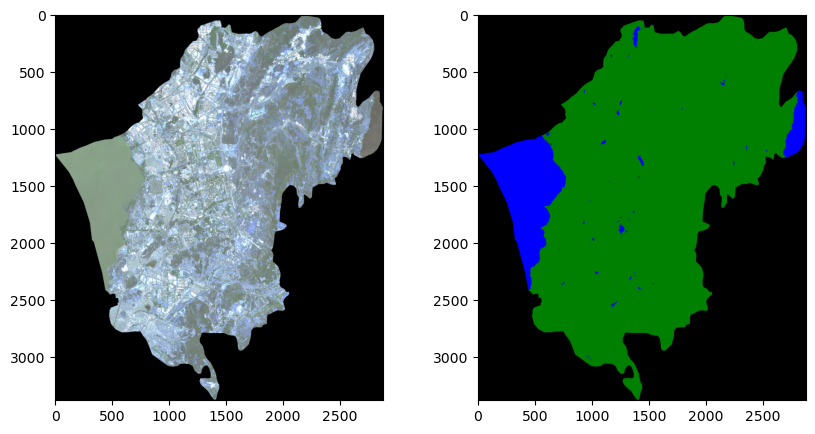

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
band_color = np.stack([rsimg_arr_nor[:,:,2],
                       rsimg_arr_nor[:,:,1],
                       rsimg_arr_nor[:,:,0]], axis=2)### rgb: red:green:blue,
band_color = band_color/(0.3-0)     ###线性拉伸
ax[0].imshow(band_color)            ###彩色显示
ax[1].imshow(y_pred_img_color)

## 分类结果的保存

In [15]:
###分类结果保存
path_result = 'E:/YNU/5/OpenSourceGIS/Act_7/OnClass/class_result.tif'
with rio.open(path_result, 'w', driver='GTiff',
              height=y_pred_img.shape[0],
              width=y_pred_img.shape[1],
              count=1,
              dtype=np.int16,
              crs=rsimg_rio.crs,
              transform=rsimg_rio.transform) as dst:
    dst.write(y_pred_img, 1)    ## the number 1 is the number of bands.